In [96]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from prophet import Prophet
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense, LSTM

from src.features import build_features
from src.models.predict_model import evaluar_desempeno_train_y_test_serie_tiempo

warnings.filterwarnings("ignore")

sns.set_style()
plt.rcParams["figure.figsize"] = (12, 6)

# Objetivo del cuadernillo

En este cuadernillo se quiere realizar el preprocesamiento de los datos de egresos hospitalarios para confeccionar un modelo de previsión de esta métrica hasta el 2035. De forma general, se utilizarán los datos desde 2001 hasta 2018 para entrenar modelos, y 2019 para evaluar los modelos. Se obviará 2020 del análisis debido a la naturaleza del año (pandemia).

- Se entrenarán 6 modelos distintos, y se seleccionará el que tenga el mejor desempeño en el conjunto de evaluación (año 2019). Los modelos a entrenar serán:

  - Prophet
  - Auto ARIMA
  - XGB
  - Hibrido
  - Feed Forward Neural Network
  - Long-Short Term Memory (LSTM)

Para simplificar el modelamiento de los datos, se harán las predicciones con una agregación de egresos mensuales.


In [98]:
# Lee la base de datos
egresos_torax = pd.read_csv("../data/processed/egresos_torax_mes_y_dia.csv")

# Crea columna de fecha en datetime
egresos_torax["FECHA_EGRESO"] = pd.to_datetime(
    egresos_torax["ANO_EGRESO"].astype(str)
    + "-"
    + egresos_torax["MES_EGRESO"].astype(str)
    + "-"
    + egresos_torax["DIA_EGRESO"].astype(str),
    format="%Y-%m-%d",
)

# Elimina columnas redundantes
egresos_torax = egresos_torax.drop(
    columns=[
        "ANO_EGRESO",
        "MES_EGRESO",
        "DIA_EGRESO",
        "ESTABLECIMIENTO_SALUD",
        "GLOSA_ESTABLECIMIENTO_SALUD",
    ]
).sort_values("FECHA_EGRESO")

# Elimina el anio 2020, debido a que es anomalo (Pandemia COVID)
egresos_torax = egresos_torax.query("FECHA_EGRESO < '2020-01-01'")

# Elige la fecha como indice de los datos
egresos_torax = egresos_torax.set_index("FECHA_EGRESO")

In [99]:
DIAGS_MAS_RELEVANTES = [
    "C33X",
    "C340",
    "C341",
    "C342",
    "C343",
    "C381",
    "C384",
    "C450",
    "C780",
    "C782",
    "D143",
    "D381",
    "E848",
    "I080",
    "I081",
    "I340",
    "I350",
    "I351",
    "I352",
    "I420",
    "I456",
    "I472",
    "I495",
    "I710",
    "I712",
    "J398",
    "J47X",
    "J679",
    "J841",
    "J848",
    "J849",
    "J860",
    "J869",
    "J90X",
    "J91X",
    "J931",
    "J955",
    "J980",
    "M348",
    "Q211",
    "Q231",
    "Q676",
    "T820",
    "T821",
    "Z450",
]

In [100]:
# Obtiene metricas agregadas por mes (suma los egresos de todos los diags por dia)
df = egresos_torax.resample("M").sum()[["n_egresos"]]
df_relevantes = (
    egresos_torax[egresos_torax["DIAG1"].isin(DIAGS_MAS_RELEVANTES)]
    .resample("M")
    .sum()[["n_egresos"]]
)

# 1. Preprocesamiento de los datos

Cada uno de los modelos requiere un preprocesamiento distinto de los datos. Por lo tanto, se creará un apartado para cada uno.


In [101]:
# Previo a cualquier preprocesamiento, se separa en train y test
CORTE_TEST = "2019-01-01"

train = df[df.index < CORTE_TEST]
test = df[df.index >= CORTE_TEST]

# Define time splitter para hacer validacion cruzada
time_splitter = TimeSeriesSplit(n_splits=5, test_size=12)

metricas = {
    "MAE": mean_absolute_error,
    "MAPE": mean_absolute_percentage_error,
}

## Prophet


In [102]:
# Preprocesa datos Prophet
train_prophet = train.reset_index().rename(columns={"FECHA_EGRESO": "ds", "n_egresos": "y"})
test_prophet = test.reset_index().rename(columns={"FECHA_EGRESO": "ds", "n_egresos": "y"})

In [103]:
# Entrena datos en Prophet
prophet = Prophet()
prophet.add_country_holidays("Chile")

# # Define the hyperparameters grid
# param_grid = {
#     "seasonality_mode": ["additive", "multiplicative"],
#     "changepoint_prior_scale": [0.001, 0.01, 0.1, 0.5],
#     # Add more hyperparameters here to tune
# }

# prophet = GridSearchCV(
#     estimator=prophet, param_grid=param_grid, scoring="neg_mean_absolute_error", cv=time_splitter
# )
prophet.fit(train_prophet)

10:57:47 - cmdstanpy - INFO - Chain [1] start processing
10:57:47 - cmdstanpy - INFO - Chain [1] done processing


Train
MAE: 27.53
MAPE: 0.07

Test
MAE: 35.46
MAPE: 0.08



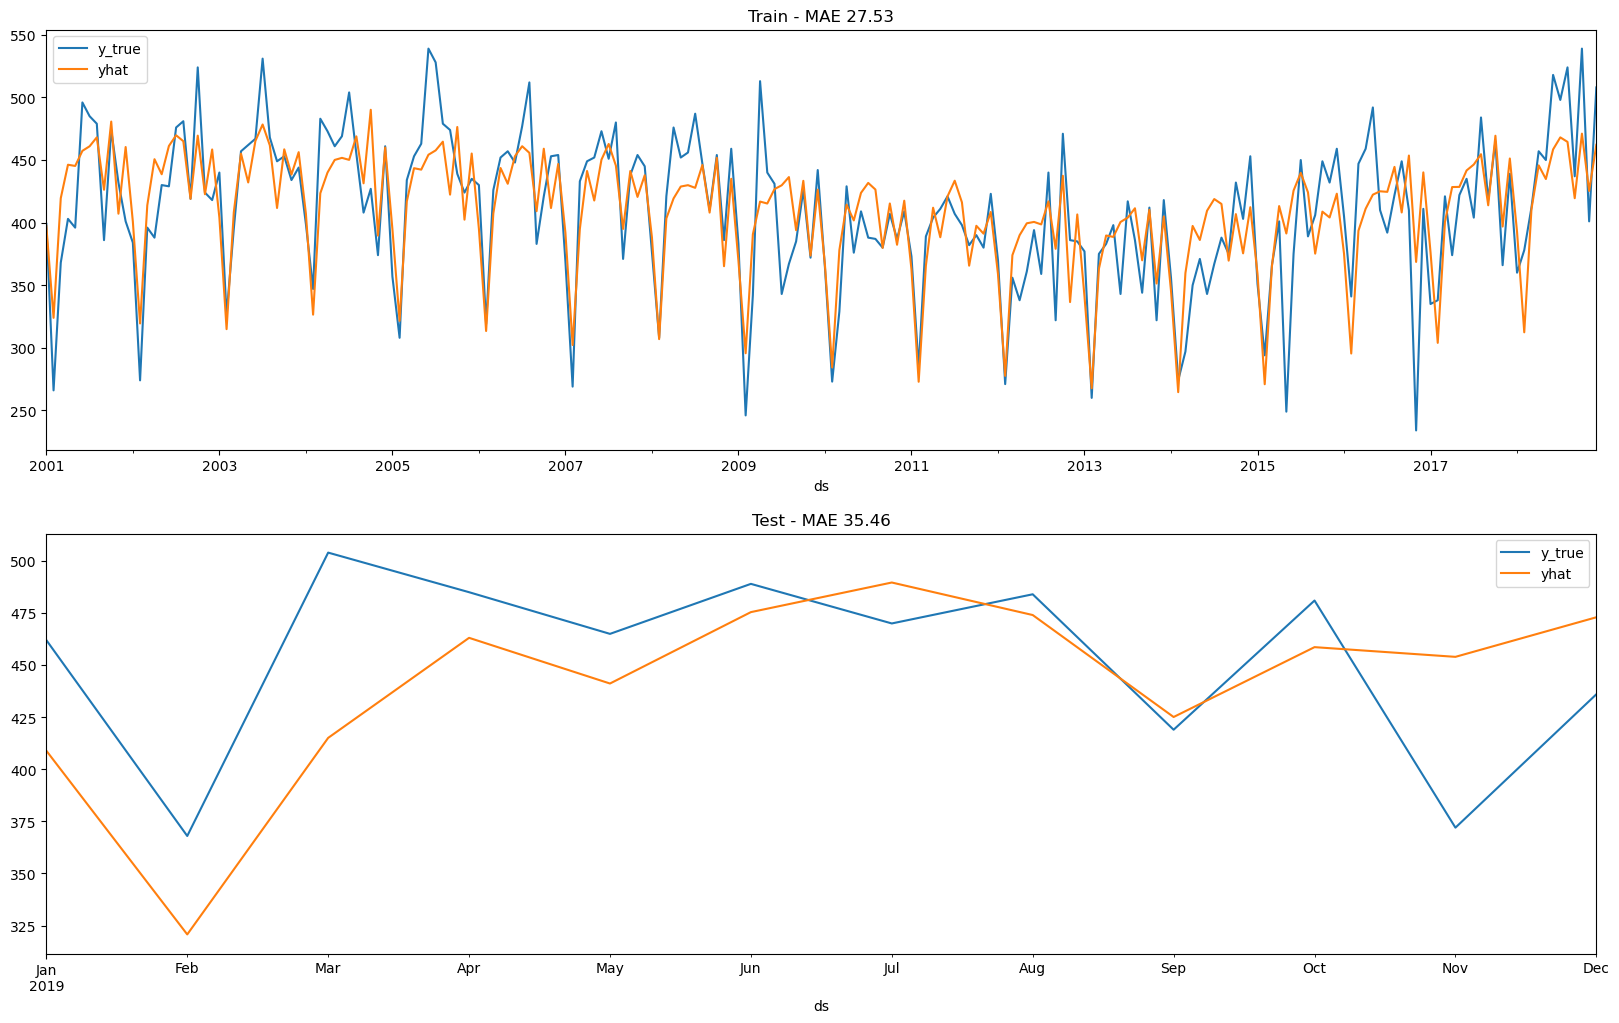

In [104]:
# Predice en conjunto de entrenamiento y testeo
yhat_train_prophet = prophet.predict(train_prophet)["yhat"]
yhat_test_prophet = prophet.predict(test_prophet)["yhat"]

resultados_prophet = evaluar_desempeno_train_y_test_serie_tiempo(
    train_prophet["ds"],
    train_prophet["y"],
    yhat_train_prophet,
    test_prophet["ds"],
    test_prophet["y"],
    yhat_test_prophet,
    metricas,
)

## Auto ARIMA


In [105]:
train_auto_arima = train["n_egresos"]
test_auto_arima = test["n_egresos"]

In [106]:
arima = auto_arima(
    train_auto_arima,
    start_p=1,
    d=1,
    start_q=1,
    max_p=5,
    max_d=5,
    max_q=5,
    m=12,
    start_P=0,
    D=1,
    start_Q=0,
    max_P=5,
    max_D=5,
    max_Q=5,
    seasonal=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
    n_fits=50,
    trace=True,
)

print(arima.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=2152.011, Time=0.09 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2239.530, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2155.577, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2084.254, Time=0.13 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2153.062, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2084.848, Time=0.31 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2084.881, Time=0.35 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2114.501, Time=0.08 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.51 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2164.901, Time=0.08 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2084.217, Time=0.25 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=2084.866, Time=0.38 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2084.834, Time=0.40 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=2115.748, Time=0.19 sec
 ARIMA(1,1,1)(1,1,2)[12]

In [107]:
sarimax = SARIMAX(train_auto_arima, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))
result_sarimax = sarimax.fit()
result_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          n_egresos   No. Observations:                  216
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1038.108
Date:                            Wed, 06 Dec 2023   AIC                           2084.217
Time:                                    10:57:54   BIC                           2097.470
Sample:                                01-31-2001   HQIC                          2089.578
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1393      0.090      1.540      0.124      -0.038       0.317
ma.L1         -0.8597      0.042    -20.241      0.000      -0.943      -0.776
ma.S.L12      -0.7569      0.061    -12.321      0.000      -0.877      -0.637
sigma2      1530.0092    123.309     12.408      0.000    1288.327    1771.691
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                75.74
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               2.08   Skew:                            -0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train
MAE: 34.48
MAPE: 0.09

Test
MAE: 32.34
MAPE: 0.07



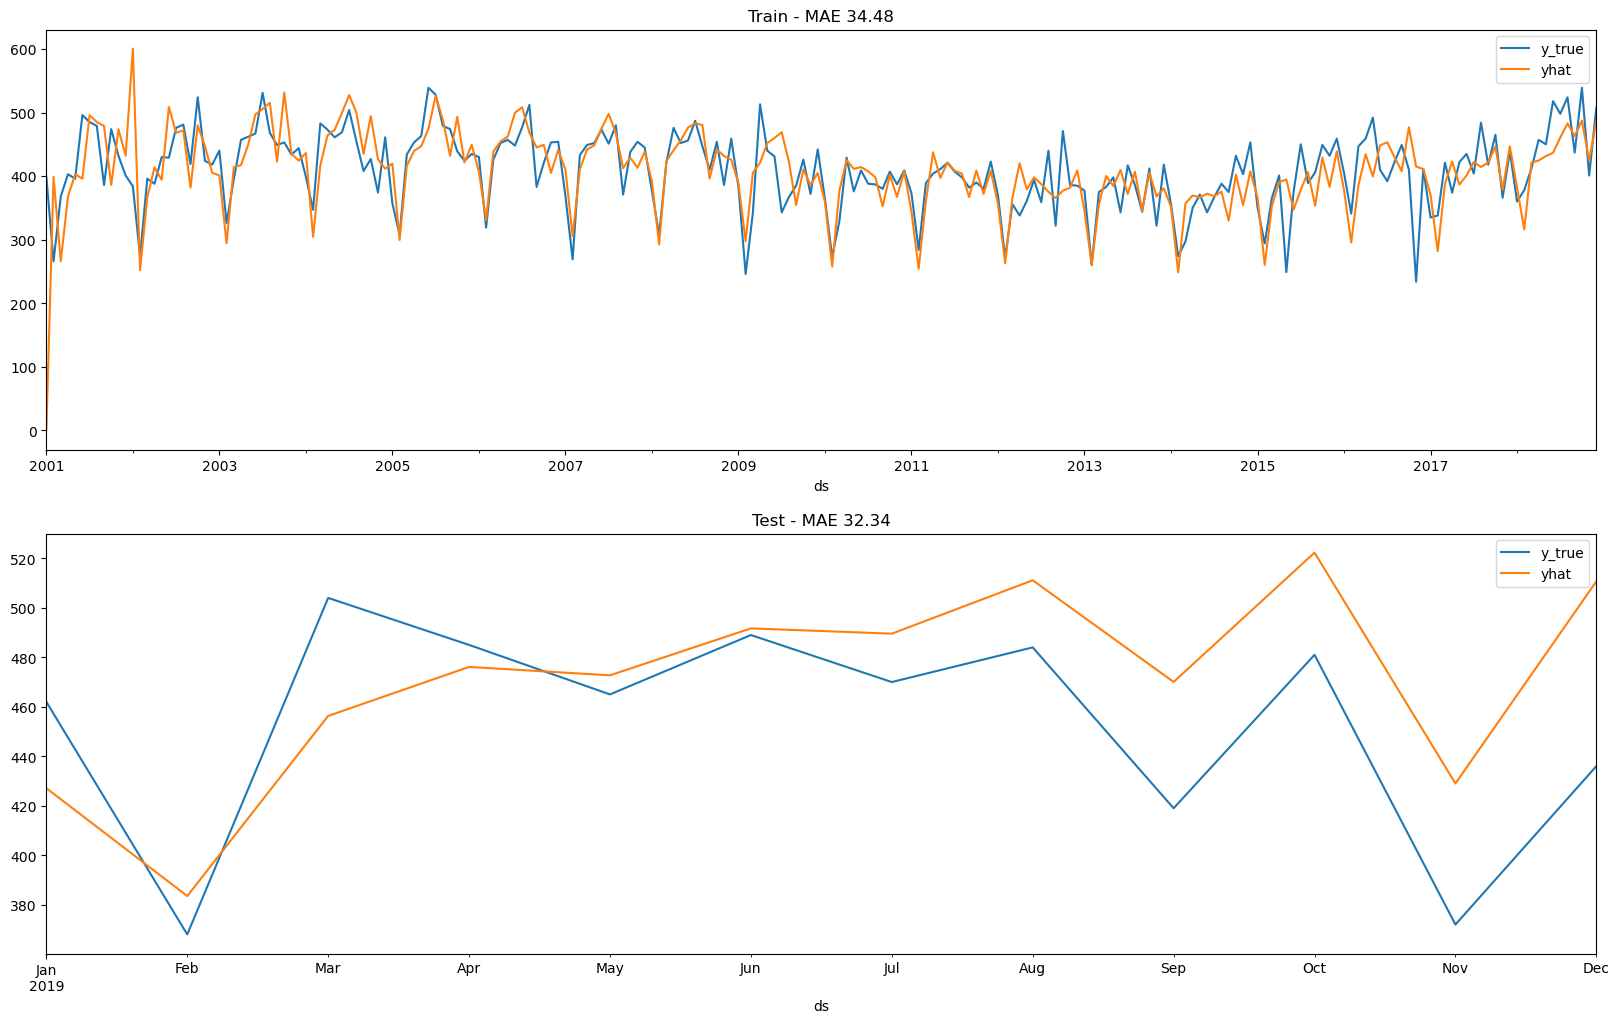

In [108]:
# Evalua metricas de rendimiento en train y test
start_index = 0
end_index = len(train_auto_arima) - 1
yhat_train_sarimax = result_sarimax.predict(start_index, end_index)

start_index = len(train_auto_arima)
end_index = start_index + len(test_auto_arima) - 1
yhat_test_sarimax = result_sarimax.predict(start_index, end_index)

# Reporta resultados
resultados_sarimax = evaluar_desempeno_train_y_test_serie_tiempo(
    train_auto_arima.index,
    train_auto_arima,
    yhat_train_sarimax,
    test_auto_arima.index,
    test_auto_arima,
    yhat_test_sarimax,
    metricas,
)

## XGB


In [109]:
# Agrega los lags significativos segun grafico de autocorrelacion
LAGS_A_AGREGAR = [1, 2, 3, 11, 12, 24]

train_xgb = build_features.add_time_series_columns(train)
train_xgb = build_features.create_lag_features(train_xgb, "n_egresos", LAGS_A_AGREGAR, fill_value=0)

test_xgb = build_features.add_time_series_columns(test)
test_xgb = build_features.create_lag_features(test_xgb, "n_egresos", LAGS_A_AGREGAR, fill_value=0)

# Separa en X e y

X_train_xgb = train_xgb.drop(columns="n_egresos")
y_train_xgb = train_xgb["n_egresos"]

X_test_xgb = test_xgb.drop(columns="n_egresos")
y_test_xgb = test_xgb["n_egresos"]

In [110]:
xgb = XGBRegressor()

param_grid_xgb = {
    "n_estimators": [100, 300, 500, 1000],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.3],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring="neg_mean_absolute_error",
    cv=time_splitter,
    verbose=10,
    n_jobs=-1,
)


xgb.fit(X_train_xgb, y_train_xgb)
print(xgb.best_params_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


In [111]:
y_train_xgb

FECHA_EGRESO
2001-01-31    399
2001-02-28    266
2001-03-31    368
2001-04-30    403
2001-05-31    396
             ... 
2018-08-31    524
2018-09-30    437
2018-10-31    539
2018-11-30    401
2018-12-31    508
Freq: M, Name: n_egresos, Length: 216, dtype: int64

Train
MAE: 11.64
MAPE: 0.03

Test
MAE: 39.66
MAPE: 0.09



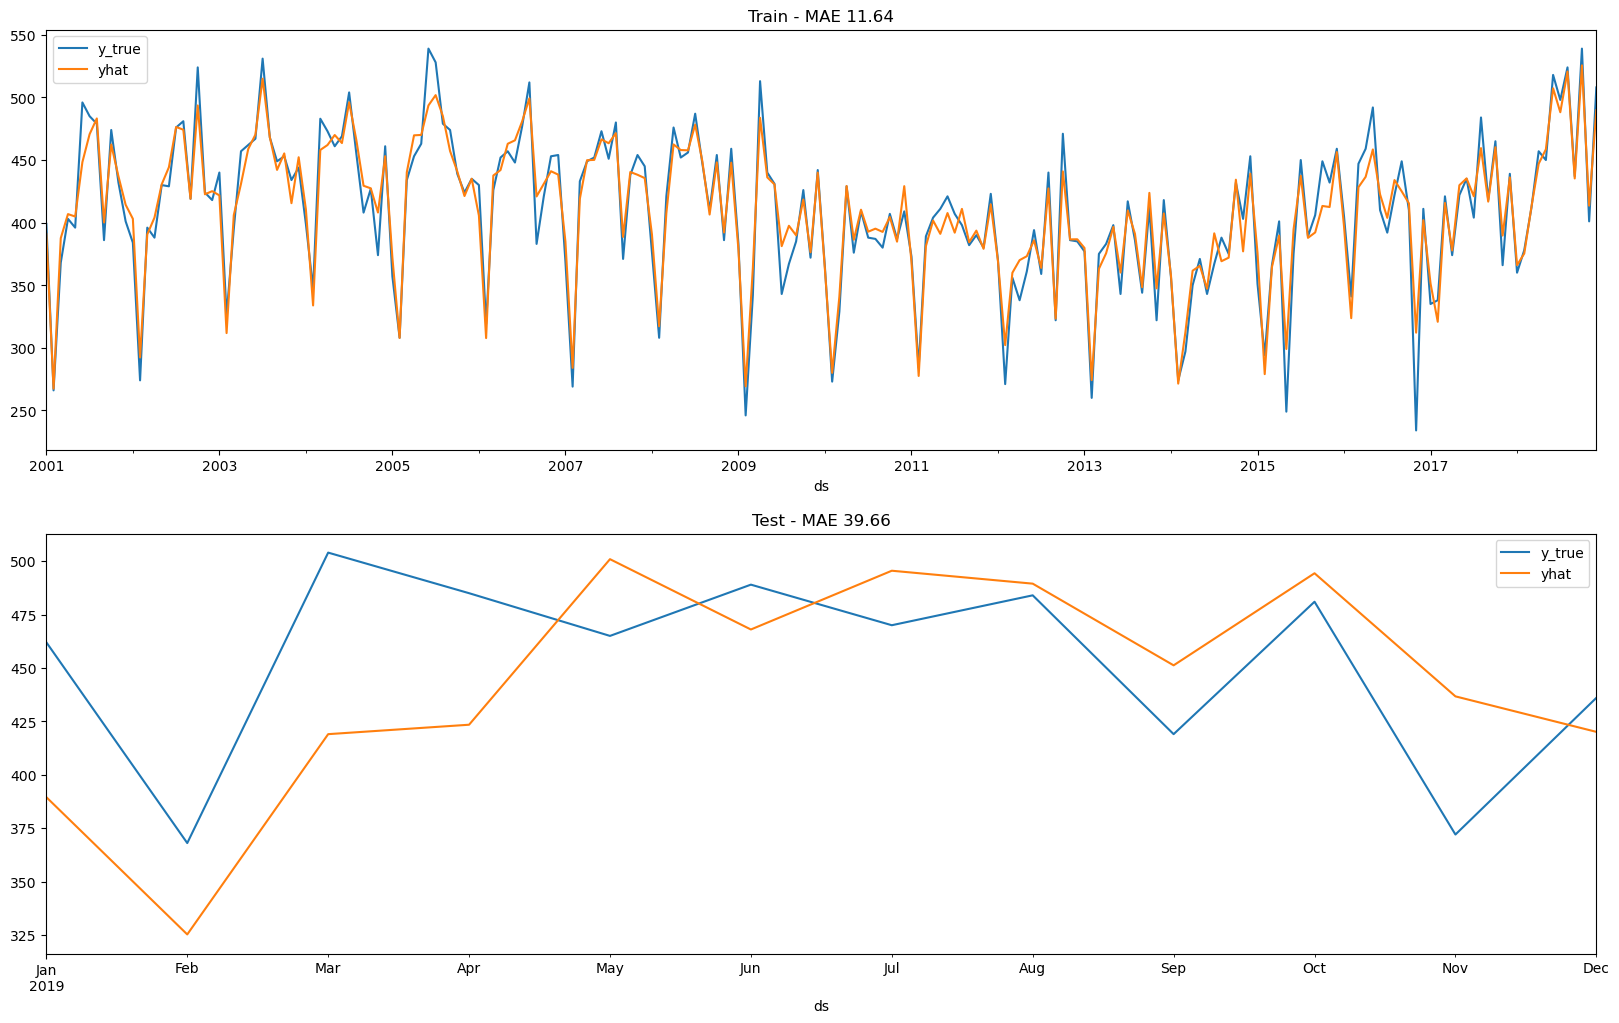

In [112]:
# Evalua metricas de rendimiento en train y test
yhat_train_xgb = xgb.predict(X_train_xgb)
yhat_test_xgb = xgb.predict(X_test_xgb)

# Reporta resultados
resultados_xgb = evaluar_desempeno_train_y_test_serie_tiempo(
    train_xgb.index,
    y_train_xgb,
    yhat_train_xgb,
    test_xgb.index,
    y_test_xgb,
    yhat_test_xgb,
    metricas,
)

## Feed Forward Neural Network


In [113]:
SEQ_SIZE = 3
n_features = 1

train_ff_nn = train.values
test_ff_nn = test.values

X_train_ff_nn, y_train_ff_nn = build_features.to_sequences(train_ff_nn, SEQ_SIZE)
X_test_ff_nn, y_test_ff_nn = build_features.to_sequences(test_ff_nn, SEQ_SIZE)

In [114]:
ff_nn = Sequential(
    [
        Dense(64, activation="relu", input_shape=[SEQ_SIZE]),
        Dense(32, activation="relu"),
        # Dense(32, activation="relu"),
        Dense(1),
    ]
)
ff_nn.compile(loss="mae", optimizer="adam", metrics=["acc"])
print(ff_nn.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                256       
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2369 (9.25 KB)
Trainable params: 2369 (9.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [115]:
history_ff_nn = ff_nn.fit(
    X_train_ff_nn,
    y_train_ff_nn,
    validation_data=(X_test_ff_nn, y_test_ff_nn),
    epochs=50,
    steps_per_epoch=10,
)

Epoch 1/50
10/10 [==============================] - 1s 15ms/step - loss: 475.7128 - acc: 0.0000e+00 - val_loss: 449.5493 - val_acc: 0.0000e+00
Epoch 2/50
10/10 [==============================] - 0s 3ms/step - loss: 361.0943 - acc: 0.0000e+00 - val_loss: 338.7086 - val_acc: 0.0000e+00
Epoch 3/50
10/10 [==============================] - 0s 5ms/step - loss: 269.4666 - acc: 0.0000e+00 - val_loss: 240.9262 - val_acc: 0.0000e+00
Epoch 4/50
10/10 [==============================] - 0s 3ms/step - loss: 177.7614 - acc: 0.0000e+00 - val_loss: 122.2019 - val_acc: 0.0000e+00
Epoch 5/50
10/10 [==============================] - 0s 5ms/step - loss: 77.0379 - acc: 0.0000e+00 - val_loss: 30.2354 - val_acc: 0.0000e+00
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 57.1571 - acc: 0.0000e+00 - val_loss: 58.3577 - val_acc: 0.0000e+00
Epoch 7/50
10/10 [==============================] - 0s 3ms/step - loss: 50.8098 - acc: 0.0000e+00 - val_loss: 26.7906 - val_acc: 0.0000e+00
Epoch 8/50


1/1 [==============================] - 0s 16ms/step
Train
MAE: 46.11
MAPE: 0.12

Test
MAE: 28.13
MAPE: 0.07



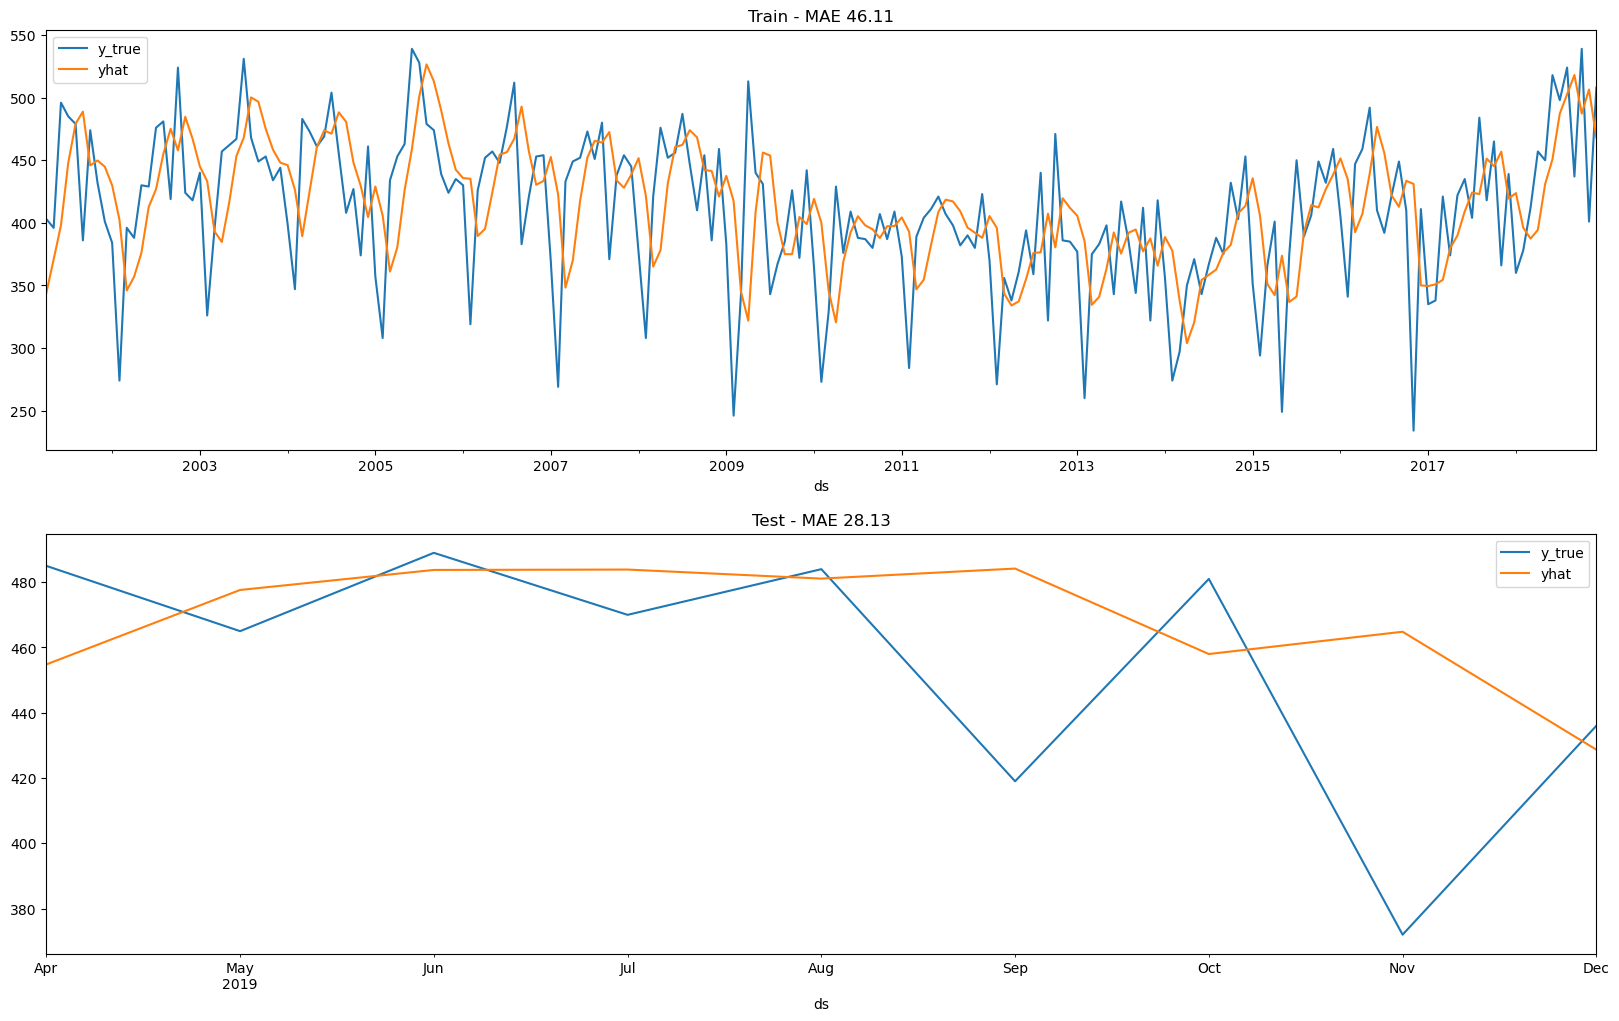

In [116]:
# Evalua metricas de rendimiento en train y test
yhat_train_ff_nn = ff_nn.predict(X_train_ff_nn)
yhat_test_ff_nn = ff_nn.predict(X_test_ff_nn)

# Reporta desempeno
resultados_ff_nn = evaluar_desempeno_train_y_test_serie_tiempo(
    train.iloc[SEQ_SIZE:].index,
    y_train_ff_nn,
    yhat_train_ff_nn.flatten(),
    test.iloc[SEQ_SIZE:].index,
    y_test_ff_nn,
    yhat_test_ff_nn.flatten(),
    metricas,
)

## Long Short Term Memory


In [117]:
SEQ_SIZE = 4
n_features = 1

train_lstm = train.values
test_lstm = test.values

X_train_lstm, y_train_lstm = build_features.to_sequences(train_lstm, SEQ_SIZE)
X_test_lstm, y_test_lstm = build_features.to_sequences(test_lstm, SEQ_SIZE)

X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], 1, X_train_lstm.shape[1]))
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], 1, X_test_lstm.shape[1]))

In [118]:
lstm = Sequential(
    [
        LSTM(32, input_shape=(None, SEQ_SIZE), return_sequences=True, activation="relu"),
        LSTM(16, activation="relu"),
        Dense(16),
        Dense(1),
    ]
)

lstm.compile(loss="mae", optimizer="adam")
print(lstm.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, None, 32)          4736      
                                                                 
 lstm_3 (LSTM)               (None, 16)                3136      
                                                                 
 dense_11 (Dense)            (None, 16)                272       
                                                                 
 dense_12 (Dense)            (None, 1)                 17        
                                                                 
Total params: 8161 (31.88 KB)
Trainable params: 8161 (31.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [119]:
history_lstm = lstm.fit(
    X_train_lstm,
    y_train_lstm,
    validation_data=(X_test_lstm, y_test_lstm),
    epochs=100,
)

Epoch 1/100
7/7 [==============================] - 2s 58ms/step - loss: 404.6784 - val_loss: 443.2599
Epoch 2/100
7/7 [==============================] - 0s 6ms/step - loss: 400.0788 - val_loss: 437.9017
Epoch 3/100
7/7 [==============================] - 0s 6ms/step - loss: 391.0590 - val_loss: 420.8701
Epoch 4/100
7/7 [==============================] - 0s 8ms/step - loss: 369.4497 - val_loss: 378.3920
Epoch 5/100
7/7 [==============================] - 0s 6ms/step - loss: 336.6223 - val_loss: 342.1431
Epoch 6/100
7/7 [==============================] - 0s 8ms/step - loss: 300.6310 - val_loss: 298.2695
Epoch 7/100
7/7 [==============================] - 0s 5ms/step - loss: 255.7339 - val_loss: 239.2029
Epoch 8/100
7/7 [==============================] - 0s 9ms/step - loss: 197.8073 - val_loss: 162.9710
Epoch 9/100
7/7 [==============================] - 0s 5ms/step - loss: 126.3244 - val_loss: 69.5122
Epoch 10/100
7/7 [==============================] - 0s 5ms/step - loss: 61.4849 - val_loss:

1/1 [==============================] - 0s 21ms/step
Train
MAE: 46.22
MAPE: 0.12

Test
MAE: 28.63
MAPE: 0.07



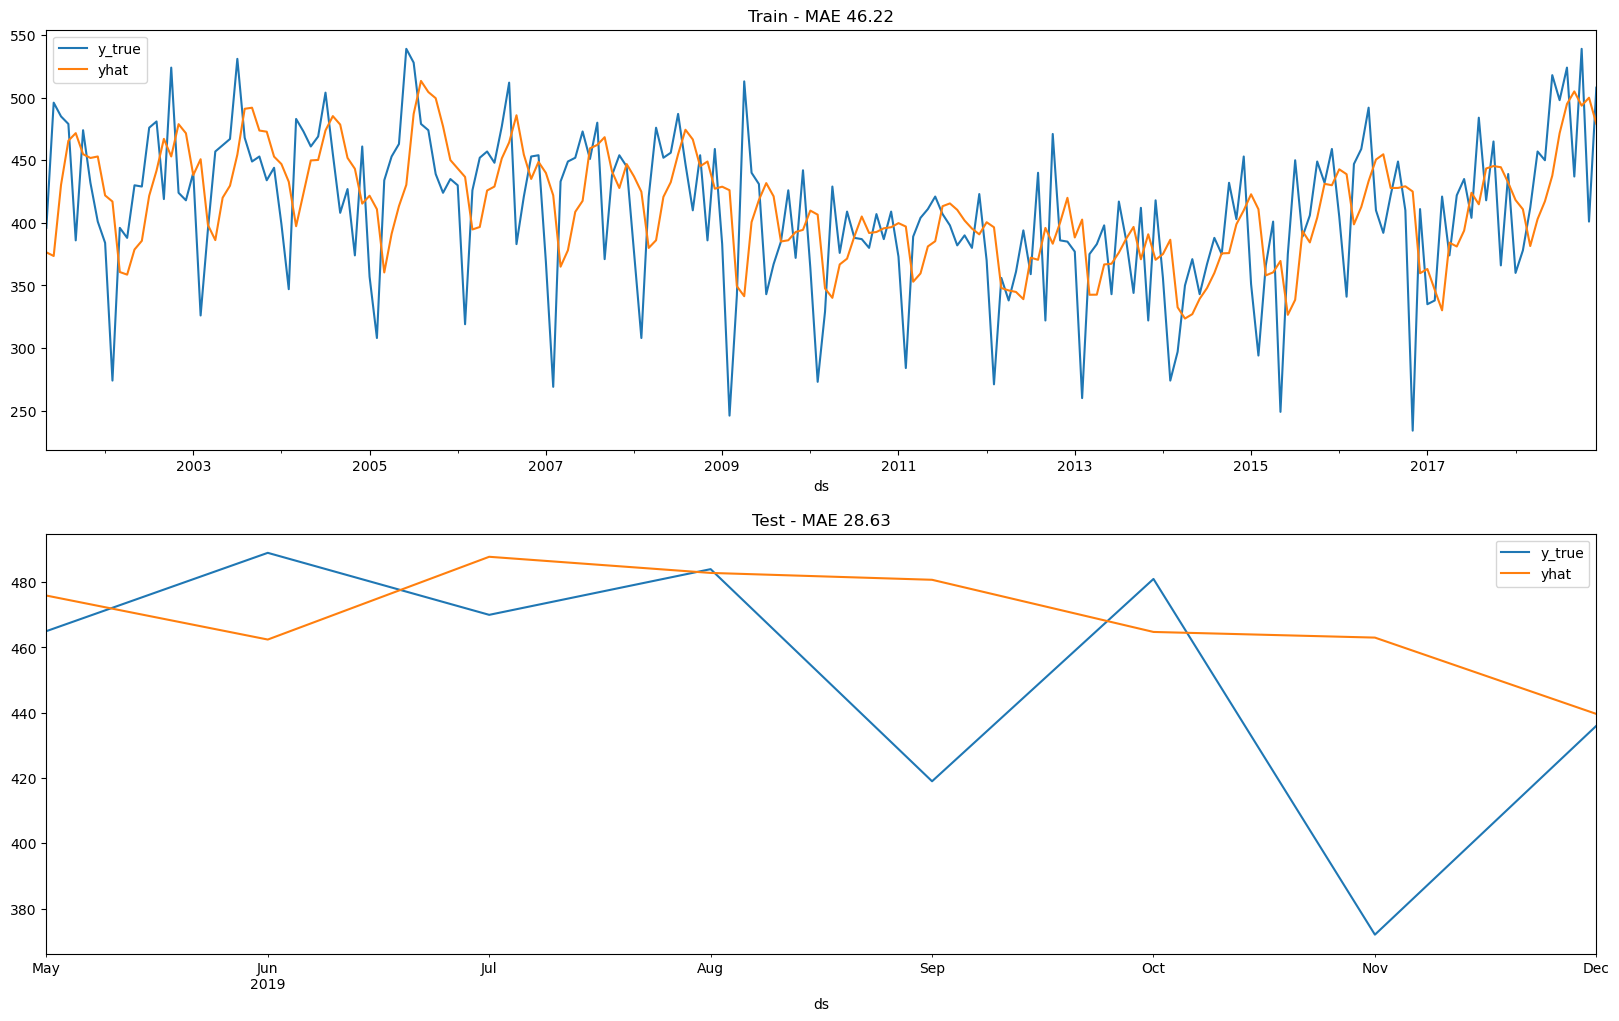

In [120]:
# Evalua metricas de rendimiento en train y test
yhat_train_lstm = lstm.predict(X_train_lstm)
yhat_test_lstm = lstm.predict(X_test_lstm)

# Reporta desempeno
resultados_lstm = evaluar_desempeno_train_y_test_serie_tiempo(
    train.iloc[SEQ_SIZE:].index,
    y_train_lstm,
    yhat_train_lstm.flatten(),
    test.iloc[SEQ_SIZE:].index,
    y_test_lstm,
    yhat_test_lstm.flatten(),
    metricas,
)